In [1]:
pip install pandas openpyxl

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import sqlite3
from datetime import datetime

In [3]:
BASE_PATH = r"C:\Users\admin\Desktop\Local Food Wastage Management System"  
DB_FILE = "food_waste.db"
EXCEL_FILE = "sql_results.xlsx"

In [4]:
PROVIDERS_CSV = os.path.join(BASE_PATH, "providers_data.csv")
RECEIVERS_CSV = os.path.join(BASE_PATH, "receivers_data.csv")
FOOD_CSV = os.path.join(BASE_PATH, "food_listings_data.csv")
CLAIMS_CSV = os.path.join(BASE_PATH, "claims_data.csv")

In [8]:
def fix_int(df: pd.DataFrame, cols):
    for col in cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    return df

def safe_df(df: pd.DataFrame, sql=None, err: Exception | None = None):
    if err is not None:
        return pd.DataFrame({"Error": [str(err)], "SQL": [sql if sql else ""]})
    if df is None or df.empty:
        return pd.DataFrame({"Message": ["No Data Found"]})
    return df

def get_excel_writer(excel_path: str):
    try:
        return pd.ExcelWriter(excel_path, engine="openpyxl")
    except Exception:
        return pd.ExcelWriter(excel_path, engine="xlsxwriter")

In [16]:
providers = pd.read_csv(PROVIDERS_CSV)
receivers = pd.read_csv(RECEIVERS_CSV)
food = pd.read_csv(FOOD_CSV)
claims = pd.read_csv(CLAIMS_CSV)

for df in (providers, receivers, food, claims):
    df.columns = df.columns.str.strip()

providers = fix_int(providers, ["Provider_ID"])
receivers = fix_int(receivers, ["Receiver_ID"])
food = fix_int(food, ["Food_ID", "Quantity", "Provider_ID"])
claims = fix_int(claims, ["Claim_ID", "Food_ID", "Receiver_ID"])

if "Expiry_Date" in food.columns:
    food["Expiry_Date"] = pd.to_datetime(food["Expiry_Date"], errors="coerce")
if "Timestamp" in claims.columns:
    claims["Timestamp"] = pd.to_datetime(claims["Timestamp"], errors="coerce")
with sqlite3.connect(DB_FILE) as conn:
    conn.execute("PRAGMA foreign_keys = ON;")

    providers.to_sql("Providers", conn, if_exists="replace", index=False)
    receivers.to_sql("Receivers", conn, if_exists="replace", index=False)
    food.to_sql("Food_Listings", conn, if_exists="replace", index=False)
    claims.to_sql("Claims", conn, if_exists="replace", index=False)

    print("Database created:", DB_FILE)

Database created: food_waste.db


In [37]:
queries = {
        "Citywise_Providers": """
            SELECT City, COUNT(*) AS Providers_Count
            FROM Providers
            GROUP BY City
        """,
        "Citywise_Receivers": """
            SELECT City, COUNT(*) AS Receivers_Count
            FROM Receivers
            GROUP BY City
        """,
        "Provider_Type_Most_Food": """
            SELECT Provider_Type, SUM(Quantity) AS Total_Quantity
            FROM Food_Listings
            GROUP BY Provider_Type
            ORDER BY Total_Quantity DESC
        """,
        "Provider_Contacts": """
            SELECT City, Name, Contact, Type AS Provider_Type
            FROM Providers
            ORDER BY City, Name
        """,
        "Top_Receivers_By_Claims": """
            SELECT r.Name, r.Type, COUNT(c.Claim_ID) AS Total_Claims
            FROM Receivers r
            LEFT JOIN Claims c ON r.Receiver_ID = c.Receiver_ID
            GROUP BY r.Name, r.Type
            ORDER BY Total_Claims DESC, r.Name
        """,
        "Total_Quantity_Available": """
            SELECT SUM(Quantity) AS Total_Quantity
            FROM Food_Listings
        """,
        "City_With_Most_Listings": """
            SELECT Location AS City, COUNT(*) AS Listings_Count
            FROM Food_Listings
            GROUP BY Location
            ORDER BY Listings_Count DESC, City
        """,
        "Common_Food_Types": """
            SELECT Food_Type, COUNT(*) AS Items_Count
            FROM Food_Listings
            GROUP BY Food_Type
            ORDER BY Items_Count DESC, Food_Type
        """,
        "Claims_Per_Food_Item": """
            SELECT Food_ID, COUNT(*) AS Claims_Count
            FROM Claims
            GROUP BY Food_ID
            ORDER BY Claims_Count DESC, Food_ID
        """,
        "Provider_Most_Completed_Claims": """
            SELECT p.Name, COUNT(*) AS Completed_Claims
            FROM Claims c
            JOIN Food_Listings f ON c.Food_ID = f.Food_ID
            JOIN Providers p ON f.Provider_ID = p.Provider_ID
            WHERE c.Status = 'Completed'
            GROUP BY p.Name
            ORDER BY Completed_Claims DESC, p.Name
        """,
        "Claim_Status_Percentage": """
            SELECT Status,
                   COUNT(*) AS Count,
                   ROUND(100.0 * COUNT(*) / (SELECT COUNT(*) FROM Claims), 2) AS Percentage
            FROM Claims
            GROUP BY Status
            ORDER BY Percentage DESC
        """,
        "Avg_Qty_Per_Receiver": """
            SELECT r.Name, ROUND(AVG(f.Quantity), 2) AS Avg_Quantity
            FROM Claims c
            JOIN Receivers r ON c.Receiver_ID = r.Receiver_ID
            JOIN Food_Listings f ON c.Food_ID = f.Food_ID
            GROUP BY r.Name
            ORDER BY Avg_Quantity DESC, r.Name
        """,
        "Most_Claimed_Meal_Type": """
            SELECT f.Meal_Type, COUNT(*) AS Claims_Count
            FROM Claims c
            JOIN Food_Listings f ON c.Food_ID = f.Food_ID
            GROUP BY f.Meal_Type
            ORDER BY Claims_Count DESC, f.Meal_Type
        """,
        "Total_Qty_By_Provider": """
            SELECT p.Name, COALESCE(SUM(f.Quantity), 0) AS Total_Quantity
            FROM Providers p
            LEFT JOIN Food_Listings f ON p.Provider_ID = f.Provider_ID
            GROUP BY p.Name
            ORDER BY Total_Quantity DESC, p.Name
        """,
        "Top_Cities_Completed_Claims": """
            SELECT f.Location AS City, COUNT(*) AS Completed_Claims
            FROM Claims c
            JOIN Food_Listings f ON c.Food_ID = f.Food_ID
            WHERE c.Status = 'Completed'
            GROUP BY f.Location
            ORDER BY Completed_Claims DESC, City
        """,
    }

In [39]:
with get_excel_writer(EXCEL_FILE) as writer:
    now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    counts = {
        "Providers": pd.read_sql_query("SELECT COUNT(*) AS cnt FROM Providers", conn)["cnt"][0],
        "Receivers": pd.read_sql_query("SELECT COUNT(*) AS cnt FROM Receivers", conn)["cnt"][0],
        "Food_Listings": pd.read_sql_query("SELECT COUNT(*) AS cnt FROM Food_Listings", conn)["cnt"][0],
        "Claims": pd.read_sql_query("SELECT COUNT(*) AS cnt FROM Claims", conn)["cnt"][0],
    }
    readme_df = pd.DataFrame(
        [
            ["Generated At", now],
            ["Database File", os.path.abspath(DB_FILE)],
            ["Excel File", os.path.abspath(EXCEL_FILE)],
            ["Providers Rows", counts["Providers"]],
            ["Receivers Rows", counts["Receivers"]],
            ["Food_Listings Rows", counts["Food_Listings"]],
            ["Claims Rows", counts["Claims"]],
        ],
        columns=["Info", "Value"],
    )
    readme_df.to_excel(writer, sheet_name="README", index=False)

    for name, sql in queries.items():
        try:
            df = pd.read_sql_query(sql, conn)
            df = safe_df(df)
        except Exception as e:
            df = safe_df(None, sql=sql, err=e)
        df.to_excel(writer, sheet_name=name[:31], index=False)

In [40]:
print("Done.")
print(f"SQLite DB: {os.path.abspath(DB_FILE)}")
print(f"Excel: {os.path.abspath(EXCEL_FILE)}")

Done.
SQLite DB: C:\Users\admin\food_waste.db
Excel: C:\Users\admin\sql_results.xlsx


In [41]:
import sqlite3, pandas as pd
conn = sqlite3.connect(r"C:\Users\admin\food_waste.db")
for t in ["Providers","Receivers","Food_Listings","Claims"]:
    print(t, pd.read_sql_query(f"SELECT COUNT(*) AS rows FROM {t}", conn))
conn.close()

Providers    rows
0  1000
Receivers    rows
0  1000
Food_Listings    rows
0  1000
Claims    rows
0  1000


In [8]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

excel_file = r"C:\Users\admin\sql_results.xlsx"
output_folder = r"C:\Users\admin\charts"

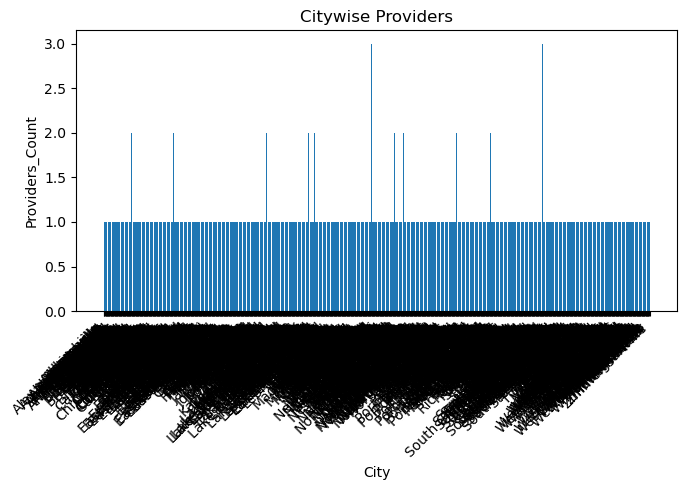

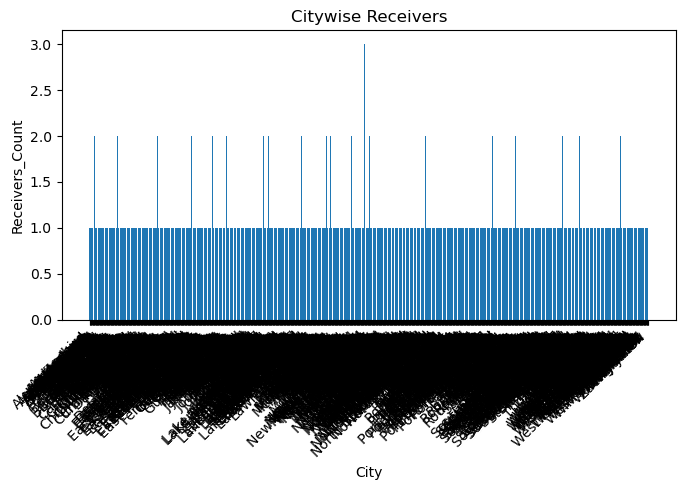

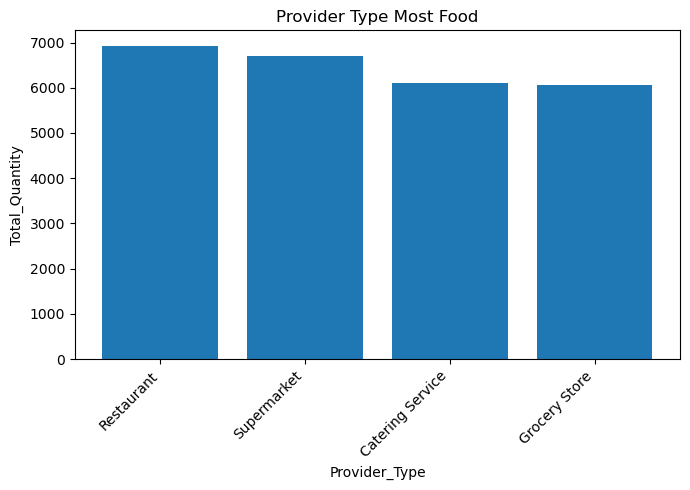

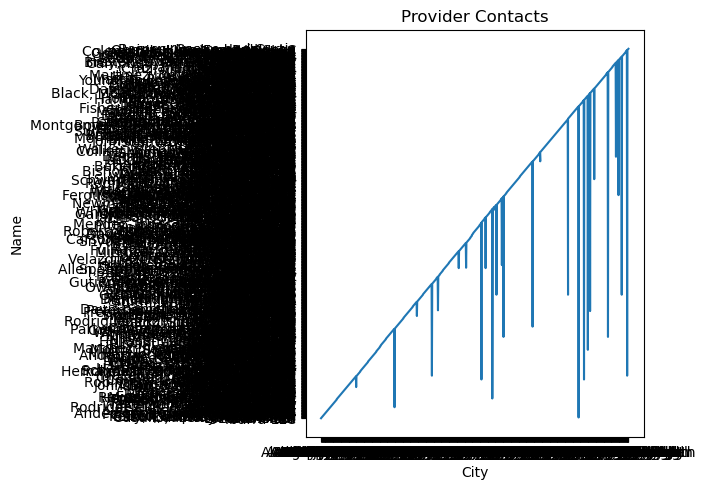

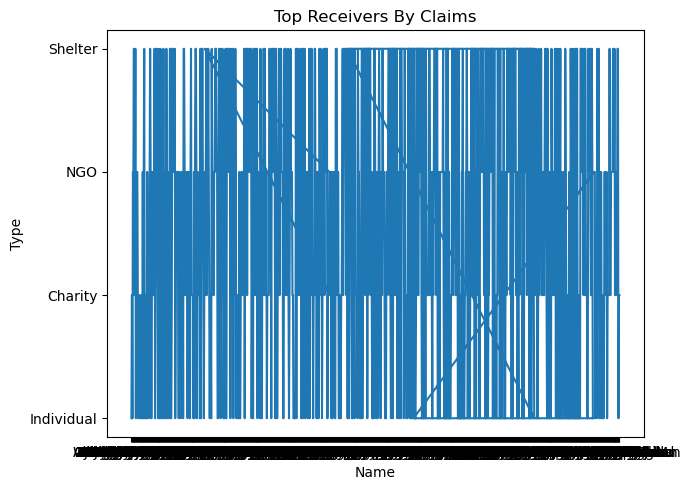

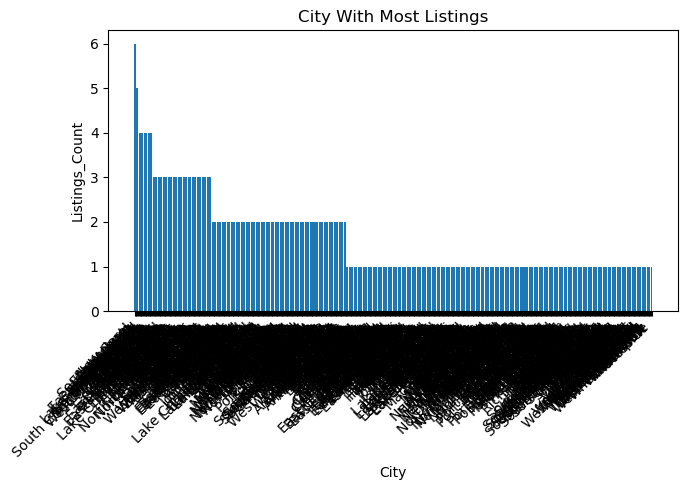

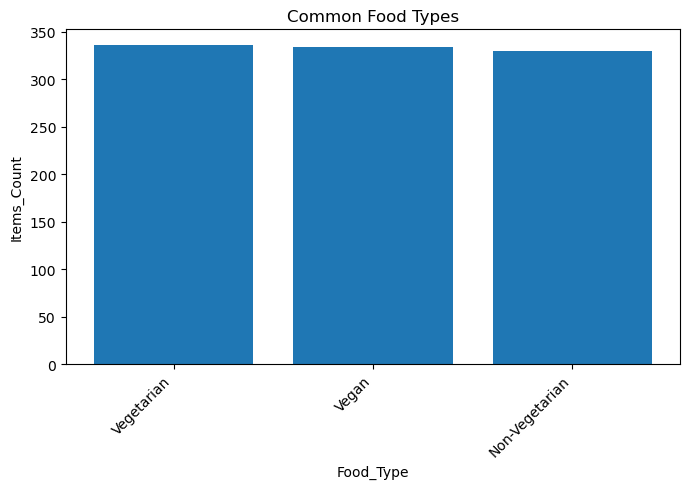

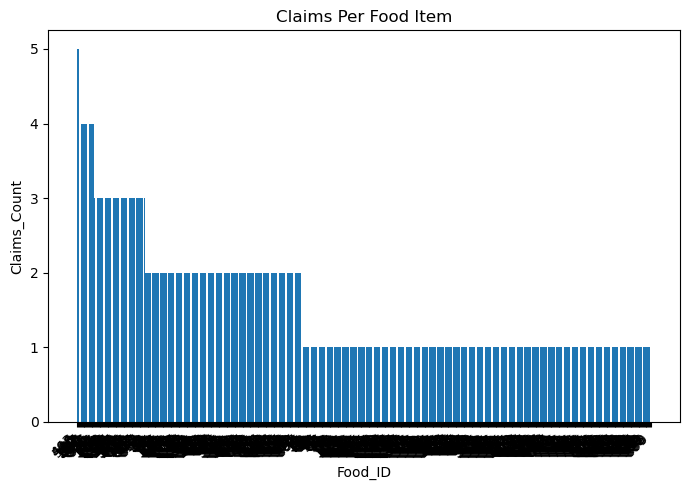

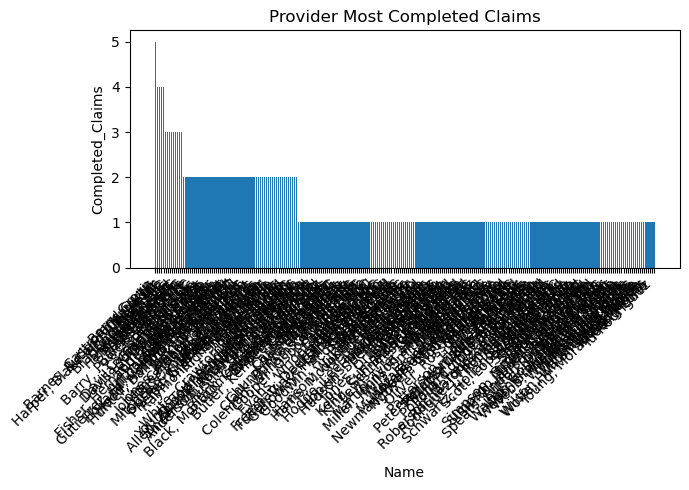

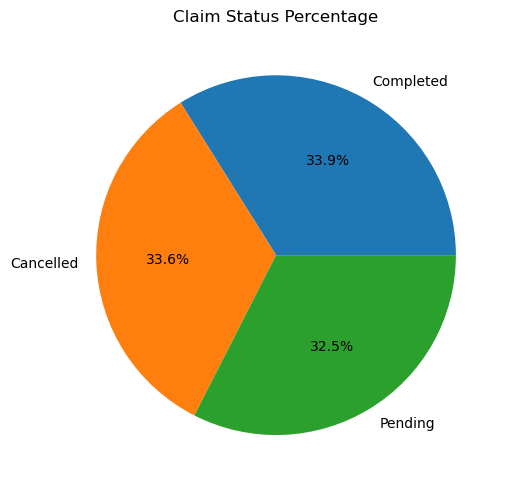

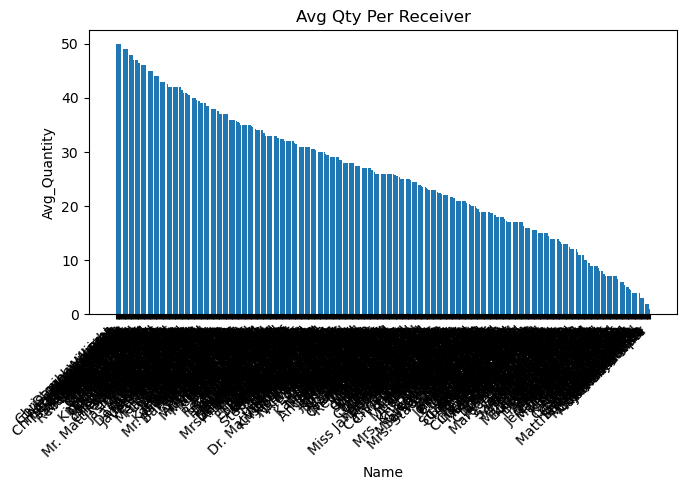

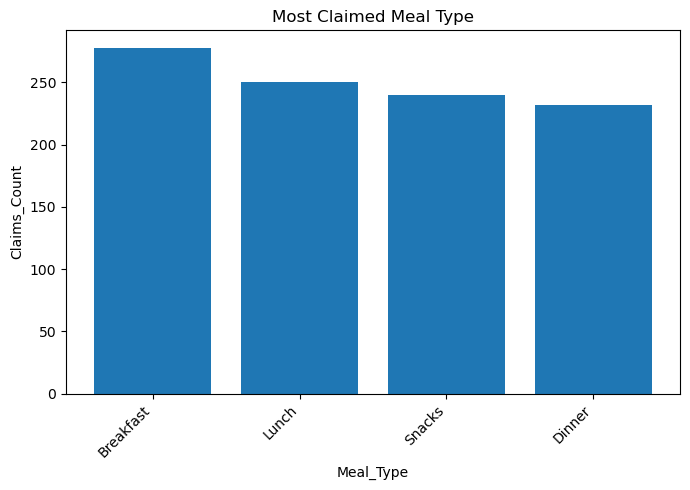

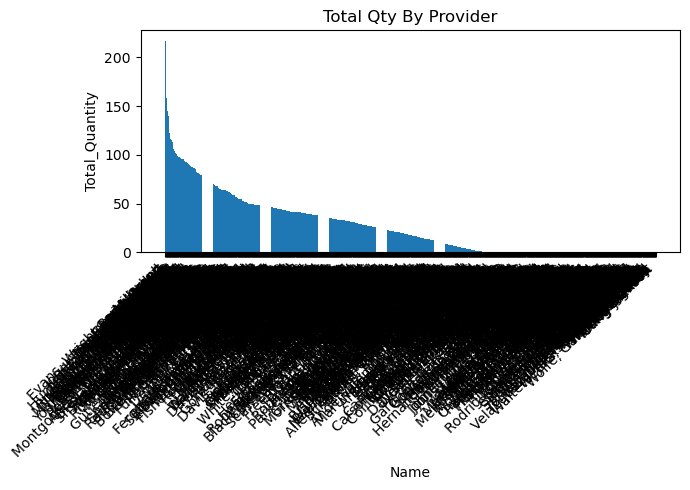

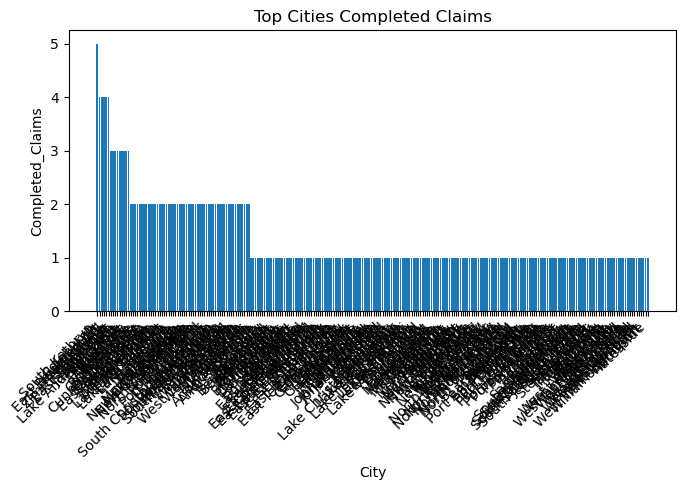

In [11]:
os.makedirs(output_folder, exist_ok=True)

log_file = rf"C:\Users\admin\chart_log_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

xls = pd.ExcelFile(excel_file)

log_data = []

for sheet in xls.sheet_names:
    if sheet.lower() == "readme":
        log_data.append([sheet, "Skipped", "README sheet"])
        continue

    df = pd.read_excel(excel_file, sheet_name=sheet)

    if df.empty:
        log_data.append([sheet, "Skipped", "Empty sheet"])
        continue

    df = df.fillna("N/A")

    if df.shape[1] < 2:
        log_data.append([sheet, "Skipped", f"Only {df.shape[1]} column"])
        continue

    plt.figure(figsize=(7, 5))

    if any("percentage" in col.lower() for col in df.columns):
        plt.pie(df[df.columns[1]], labels=df[df.columns[0]], autopct='%1.1f%%')
        plt.title(sheet.replace("_", " "))

    elif df.shape[1] == 2:
        col_x, col_y = df.columns[0], df.columns[1]
        plt.bar(df[col_x].astype(str), df[col_y])
        plt.xlabel(col_x)
        plt.ylabel(col_y)
        plt.title(sheet.replace("_", " "))
        plt.xticks(rotation=45, ha='right')

    else:
        plt.plot(df[df.columns[0]], df[df.columns[1]])
        plt.xlabel(df.columns[0])
        plt.ylabel(df.columns[1])
        plt.title(sheet.replace("_", " "))

    save_path = os.path.join(output_folder, f"{sheet}.png")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()  
    plt.close()

    log_data.append([sheet, "Chart Saved", save_path])

log_df = pd.DataFrame(log_data, columns=["Sheet Name", "Status", "Details"])
log_df["Run Time"] = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
log_df.to_excel(log_file, index=False)

In [10]:
print("\n All possible charts saved in:", output_folder)
print(" Log file saved at:", log_file)


 All possible charts saved in: C:\Users\admin\charts
 Log file saved at: C:\Users\admin\chart_log_20250814_111900.xlsx
